In [1]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hclust
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cut_tree, fcluster
from scipy.stats import chi2_contingency

In [2]:
df_log = pd.read_csv("CGS_data/data/SRP073813/SRP073813_log.csv")
df_meta = pd.read_csv("CGS_data/data/SRP073813/SRP073813_meta.csv")

In [3]:
df_log.set_index("HUGO", inplace = True)
df_meta.set_index("ID", inplace = True) #Setting the index for data makes the enrichment analysis easier
df_meta = df_meta['refinebio_subject'] #removes unnecessary data 

In [4]:
df_meta = df_meta.to_frame()

In [5]:
df_log =round(df_log) 
df_log = df_log.T #swaps columns and indexes
df_log = df_log.join(df_meta)

In [6]:
df_log = df_log.loc[:, ~df_log.columns.duplicated()] #removes duplicate columns prevent deseq

In [7]:
#Transfomring the data to contain only data collected from a certain part of the brain in our patients 
df_log = df_log[df_log["refinebio_subject"].str.contains('nacc')]
df_meta = df_meta[df_meta["refinebio_subject"].str.contains('nacc')] 

In [8]:
df_log.drop("refinebio_subject",axis =1,inplace = True)

In [9]:
df_log = df_log.T

In [10]:
df_log

,SRR3438559,SRR3438560,SRR3438561,SRR3438562,SRR3438615,SRR3438616,SRR3438617,SRR3438618,SRR3438619,SRR3438620,...,SRR3438856,SRR3438863,SRR3438869,SRR3438891,SRR3438897,SRR3438899,SRR3438902,SRR3438903,SRR3438904,SRR3438905
TSPAN6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
TNMD,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DPM1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
SCYL3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
FIRRM,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NOTCH2NLC,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0
ARMCX5-GPRASP2,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
LOC112268419,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
LOC124903324,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
#get variacne sort by it and select the top ones to do Hclust on
df_log["variance"] = np.var(df_log.values, axis=1)
df = df_log.sort_values("variance", ascending=False)
df.drop("variance", axis =1, inplace = True)
dfTen = df.head(10)
dfHun = df.head(100)
dfThous = df.head(1000)
dfTenThous = df.head(10000)
dfFiveThous = df.head(5000)


In [12]:
dfTen = dfTen.T
dfHun = dfHun.T
dfThous = dfThous.T
dfTenThous = dfTenThous.T
dfFiveThous = dfFiveThous.T

In [29]:
dfFiveThous

,CHI3L1,PENK,PTPN5,SYNDIG1L,XIST,HSPA1A,RAP1GAP,PEG3,MOBP,NRGN,...,SCFD1,MMP28,VLDLR,ENAM,LINC01980,ICE2,ZXDC,LL22NC03-63E9.3,refinebio_subject,hclust
SRR3438559,2.0,5.0,6.0,7.0,4.0,5.0,6.0,5.0,7.0,6.0,...,2.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,nacc_schizophrenia,4
SRR3438560,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,5.0,7.0,...,2.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0,nacc_control,4
SRR3438561,3.0,6.0,7.0,7.0,2.0,4.0,7.0,5.0,5.0,6.0,...,2.0,3.0,2.0,2.0,1.0,3.0,3.0,1.0,nacc_control,4
SRR3438562,3.0,6.0,7.0,7.0,4.0,4.0,7.0,6.0,5.0,6.0,...,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,nacc_schizophrenia,2
SRR3438615,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,4.0,7.0,...,2.0,3.0,3.0,1.0,2.0,2.0,2.0,1.0,nacc_control,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3438899,2.0,5.0,6.0,7.0,2.0,4.0,6.0,6.0,7.0,7.0,...,3.0,2.0,3.0,2.0,1.0,3.0,2.0,2.0,nacc_major depression,4
SRR3438902,3.0,2.0,3.0,3.0,2.0,7.0,3.0,4.0,7.0,3.0,...,2.0,3.0,3.0,1.0,1.0,3.0,3.0,2.0,nacc_schizophrenia,3
SRR3438903,3.0,3.0,5.0,6.0,2.0,4.0,6.0,6.0,6.0,6.0,...,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,nacc_schizophrenia,3
SRR3438904,5.0,3.0,5.0,4.0,2.0,7.0,5.0,4.0,7.0,5.0,...,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,nacc_schizophrenia,3


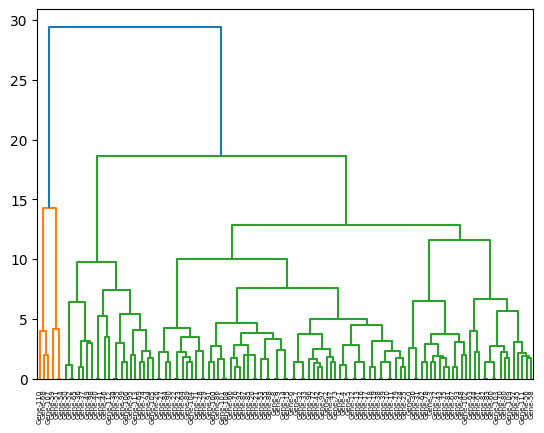

In [13]:
linkage_matrix = hclust.linkage(dfTen, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfTen.shape[0])])
plt.show()

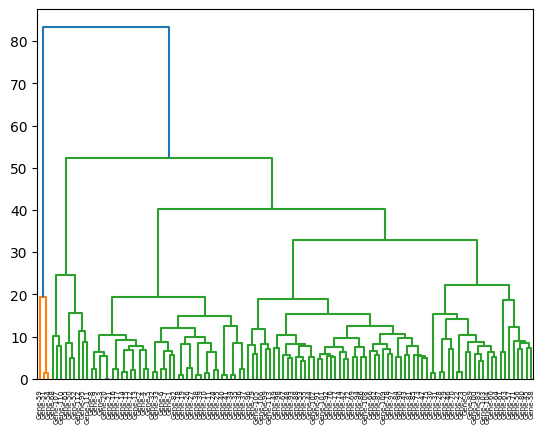

In [14]:
linkage_matrix = hclust.linkage(dfHun, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfHun.shape[0])])
plt.show()

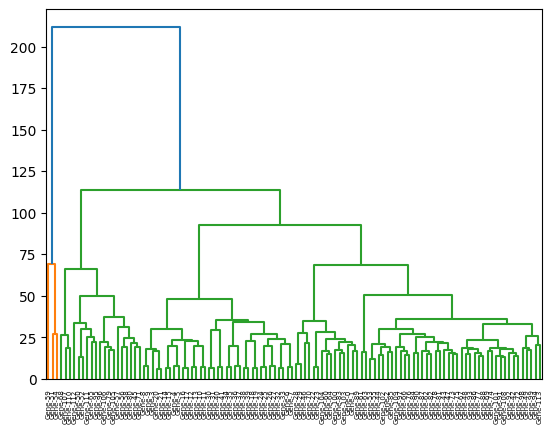

In [15]:
linkage_matrix = hclust.linkage(dfThous, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfThous.shape[0])])
plt.show()

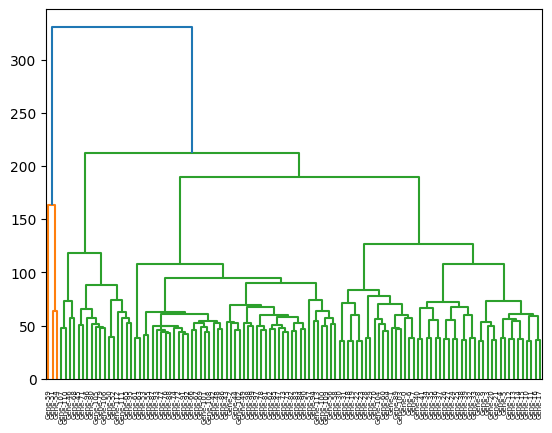

In [16]:
linkage_matrix = hclust.linkage(dfTenThous, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfTenThous.shape[0])])
plt.show()

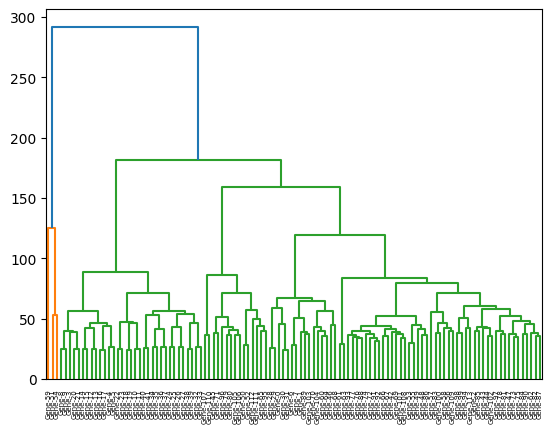

In [17]:
linkage_matrix = hclust.linkage(dfFiveThous, method = 'ward')
hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfFiveThous.shape[0])])
plt.show()

In [18]:
dfFiveThous = dfFiveThous.apply(pd.to_numeric, errors='coerce')

In [19]:
dfFiveThous = dfFiveThous.dropna()

In [20]:
dfFiveThous

,CHI3L1,PENK,PTPN5,SYNDIG1L,XIST,HSPA1A,RAP1GAP,PEG3,MOBP,NRGN,...,KLHDC7B,ADAM20,SCFD1,MMP28,VLDLR,ENAM,LINC01980,ICE2,ZXDC,LL22NC03-63E9.3
SRR3438559,2.0,5.0,6.0,7.0,4.0,5.0,6.0,5.0,7.0,6.0,...,2.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0
SRR3438560,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,5.0,7.0,...,1.0,1.0,2.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0
SRR3438561,3.0,6.0,7.0,7.0,2.0,4.0,7.0,5.0,5.0,6.0,...,1.0,1.0,2.0,3.0,2.0,2.0,1.0,3.0,3.0,1.0
SRR3438562,3.0,6.0,7.0,7.0,4.0,4.0,7.0,6.0,5.0,6.0,...,2.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0
SRR3438615,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,4.0,7.0,...,2.0,1.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3438899,2.0,5.0,6.0,7.0,2.0,4.0,6.0,6.0,7.0,7.0,...,1.0,2.0,3.0,2.0,3.0,2.0,1.0,3.0,2.0,2.0
SRR3438902,3.0,2.0,3.0,3.0,2.0,7.0,3.0,4.0,7.0,3.0,...,1.0,1.0,2.0,3.0,3.0,1.0,1.0,3.0,3.0,2.0
SRR3438903,3.0,3.0,5.0,6.0,2.0,4.0,6.0,6.0,6.0,6.0,...,1.0,2.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0
SRR3438904,5.0,3.0,5.0,4.0,2.0,7.0,5.0,4.0,7.0,5.0,...,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0


C:\Users\Shlok\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\Shlok\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


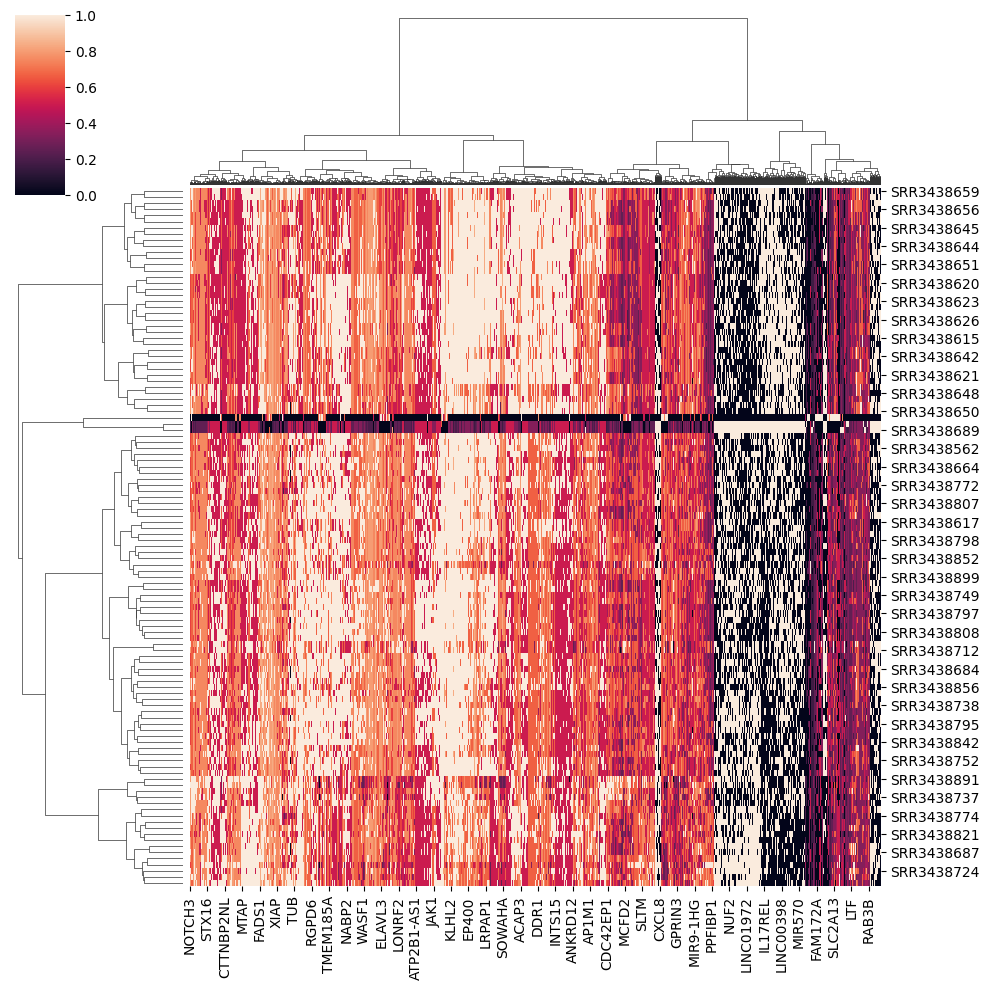

In [21]:
sns.clustermap(dfFiveThous, metric="euclidean", standard_scale=1, method="ward")
plt.show()

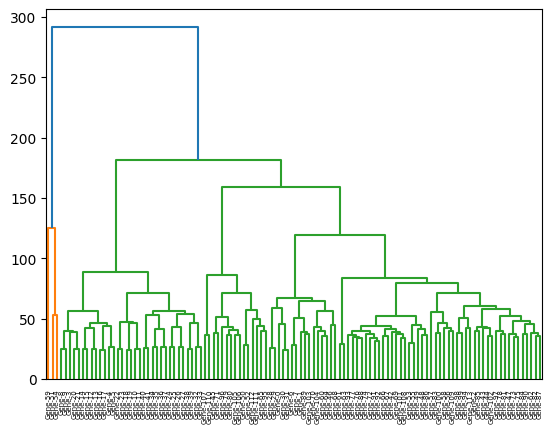

In [22]:
dend = hclust.dendrogram(linkage_matrix,labels=[f'Gene-{i}' for i in range(dfFiveThous.shape[0])])

In [23]:
#Transform data for R-stuido to create SANKEY PLOT
data = df
# Define the number of clusters
num_clusters = 4

# Define a function to perform hierarchical clustering and return cluster memberships
def hierarchical_clustering(data, num_clusters):
    # Calculate the distance matrix
    distance_matrix = pdist(data.T, 'euclidean')
        # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # Cut the dendrogram to get cluster labels
    cluster_labels = cut_tree(linkage_matrix, n_clusters=num_clusters).flatten()
    
    return cluster_labels

In [24]:
# Define subsets for clustering
gene_subsets = [10, 100, 1000, 10000]

# Store results
results = {}

for subset in gene_subsets:
    top_genes = data.var(axis=1).nlargest(subset)
    data_subset = data.loc[top_genes.index]
    
    # Get cluster memberships for the subset
    cluster_labels = hierarchical_clustering(data_subset, num_clusters)
    
    results[f"X{subset}"] = cluster_labels

In [25]:
# Convert results to DataFrame and save to CSV
df = pd.DataFrame(results)
df['Sample'] = data.columns
df.to_csv("CGS_Data/data/SRP073813/Sankey_plot.csv", index=False)

In [26]:
unique_groups= df_meta["refinebio_subject"].unique()
unique_groups= np.delete( unique_groups, 1)

In [27]:
dfFiveThous = dfFiveThous.join(df_meta, how = "inner")
dfFiveThous 

,CHI3L1,PENK,PTPN5,SYNDIG1L,XIST,HSPA1A,RAP1GAP,PEG3,MOBP,NRGN,...,ADAM20,SCFD1,MMP28,VLDLR,ENAM,LINC01980,ICE2,ZXDC,LL22NC03-63E9.3,refinebio_subject
SRR3438559,2.0,5.0,6.0,7.0,4.0,5.0,6.0,5.0,7.0,6.0,...,1.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,nacc_schizophrenia
SRR3438560,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,5.0,7.0,...,1.0,2.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0,nacc_control
SRR3438561,3.0,6.0,7.0,7.0,2.0,4.0,7.0,5.0,5.0,6.0,...,1.0,2.0,3.0,2.0,2.0,1.0,3.0,3.0,1.0,nacc_control
SRR3438562,3.0,6.0,7.0,7.0,4.0,4.0,7.0,6.0,5.0,6.0,...,1.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,nacc_schizophrenia
SRR3438615,3.0,6.0,7.0,7.0,2.0,5.0,6.0,5.0,4.0,7.0,...,1.0,2.0,3.0,3.0,1.0,2.0,2.0,2.0,1.0,nacc_control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3438899,2.0,5.0,6.0,7.0,2.0,4.0,6.0,6.0,7.0,7.0,...,2.0,3.0,2.0,3.0,2.0,1.0,3.0,2.0,2.0,nacc_major depression
SRR3438902,3.0,2.0,3.0,3.0,2.0,7.0,3.0,4.0,7.0,3.0,...,1.0,2.0,3.0,3.0,1.0,1.0,3.0,3.0,2.0,nacc_schizophrenia
SRR3438903,3.0,3.0,5.0,6.0,2.0,4.0,6.0,6.0,6.0,6.0,...,2.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,nacc_schizophrenia
SRR3438904,5.0,3.0,5.0,4.0,2.0,7.0,5.0,4.0,7.0,5.0,...,1.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,nacc_schizophrenia


In [28]:
clusters_samples = fcluster(linkage_matrix, 4, criterion='maxclust')
dfFiveThous["hclust"] = clusters_samples

# Assign cluster labels to samples

# Perform pairwise Chi-squared tests for each group against cluster labels
chi2_results= []

for group in unique_groups:
    group_data = df_meta[df_meta["refinebio_subject"].isin([group, "nacc_control"])]
    contingency_table = pd.crosstab(group_data["refinebio_subject"], dfFiveThous["hclust"])
    chi2_stat, p_val, dof, _ = chi2_contingency(contingency_table)
    
    chi2_results.append({
        "Comparison": f"{group} vs Control",
        "Test Statistic (Chi2)": chi2_stat,
        "p-value": p_val,
        "Degrees of Freedom": dof
    })


# Convert results to a DataFrame
chi2_results = pd.DataFrame(chi2_results)

chi2_results

,Comparison,Test Statistic (Chi2),p-value,Degrees of Freedom
0,nacc_schizophrenia vs Control,4.768226,0.092171,2
1,nacc_major depression vs Control,3.400694,0.333872,3
2,nacc_bipolar disorder vs Control,3.145769,0.369692,3
